In [236]:
import psycopg2 as pg2
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pymatch.Matcher import Matcher

%matplotlib inline
plt.style.use('ggplot')

In [274]:
conn = pg2.connect(user='postgres',  dbname='scrabble', host='localhost', port='5432', password='myPassword')
cur = conn.cursor()


sql = """SELECT  movenum, turn_score, p2_rating as rating, rack
from FullView where gamenum in (SELECT gamenum from fullP2games) and NOT is_challenge and
gamenum not in (select game_num from bad_games) and
is_player2 = ' 1' and length(rack) = 7 """

sql +=  """ UNION SELECT movenum, turn_score, p1_rating as rating, rack
from FullView where gamenum in (SELECT gamenum from fullP1games) and NOT is_challenge and
gamenum not in (select game_num from bad_games) and
is_player2 = ' 0' and length(rack) = 7 ORDER BY movenum"""


df_good_p2 = pd.read_sql(sql ,con=conn)
#df_good_p2 = df_good_p2[df_good_p2.rack.apply(len) <= 7]
#df_good_p2.rack = df_good_p2.rack.apply(sorted)
#df_good_p2.rack

In [270]:
class TileCondition:
    def __init__(self, letter, count, compare):
        self._letter = letter
        self._count = count
        self._compare = compare
    def get_lambda(self):
        if (self._compare=="=="):
            return lambda x: x.count(self._letter)== self._count
        if (self._compare=="<"):
            return lambda x: x.count(self._letter) < self._count
        if (self._compare==">"):
            return lambda x: x.count(self._letter) > self._count
        if (self._compare==">="):
            return lambda x: x.count(self._letter) >= self._count
        if (self._compare=="<="):
            return lambda x: x.count(self._letter) <= self._count
        if (self._compare=="!="):
            return lambda x: x.count(self._letter) != self._count        
        
    def get_label(self):
        if (self._compare=="=="):
            return "Exactly {:} {:}'s".format(self._count, self._letter)
        if (self._compare=="<"):
            return "Less than {:} {:}'s".format(self._count, self._letter)
        if (self._compare==">"):
            return "More than {:} {:}'s".format(self._count, self._letter)
        if (self._compare=="<="):
            return "{:} or less {:}'s".format(self._count, self._letter)
        if (self._compare==">="):
            return "{:} or more {:}'s".format(self._count, self._letter)
        if (self._compare=="!="):
            return "Does not have {:} {:}'s".format(self._count, self._letter)
    
    def get_opposite(self):
        if (self._compare=="=="):
            cond = "!="
        if (self._compare=="<"):
            cond= ">="
        if (self._compare==">"):
            cond="<="
        if (self._compare=="<="):
            cond=">"
        if (self._compare==">="):
            cond= "<"
        if (self._compare=="!="):
            cond = "=="
        return TileCondition(self._letter, self._count, cond)


In [272]:




def evaluate(conditions1, conditions2=None):
    fig, axes = plt.subplots()
    if not conditions2:
        conditions2 = [conditions1[0].get_opposite()]
    #print(conditions2)
    control = df_good_p2[df_good_p2.rack.apply(conditions1[0].get_lambda())]
    test = df_good_p2[df_good_p2.rack.apply(conditions2[0].get_lambda())]
    if (control.shape[0]):
        print("mean score with {:}: {:}, ({:})".format(conditions1[0].get_label(), round(np.mean(control["turn_score"]), 2), 
                                                   control.shape[0]))
        print("mean score with {:}: {:}, ({:})".format(conditions2[0].get_label(), round(np.mean(test["turn_score"]), 2), 
                                                   test.shape[0]))


        print("Score p-value: %.3f" % stats.ttest_ind(control.turn_score, test.turn_score).pvalue)

#    m = Matcher(control, test, yvar="turn_score", exclude=["rack"])
    print(control.shape, test.shape)
    print (np.mean(control['rating']))
    print (np.mean(test['rating']))
    axes.hist(tdf["turn_score"], bins=100, density=True, alpha = .5, color='black', label=conditions1[0].get_label())
    axes.hist(tdf2["turn_score"], bins=100, density=True, alpha=.5, label=conditions2[0].get_label())
    axes.legend()
    axes.set_xlim(left=0, right=150)
    axes.set_ylim(bottom=0, top =.1)
    print(" ")  
    return test


In [275]:
df_good_p2

,movenum,turn_score,rating,rack
0,1,28,2152,BEFGIRS
1,1,14,2077,GILOSUW
2,1,0,2012,EGHIOOO
3,1,8,1943,DEEINOT
4,1,18,1742,AAFMOOV
...,...,...,...,...
363456,43,12,-1,ILNNRUV
363457,43,4,-1,AEGIRRU
363458,44,38,-1,ABEHITX
363459,45,19,-1,?INSSSU


mean score with Less than 1 A's: 32.82, (188246)
mean score with 1 or more A's: 35.48, (175215)
Score p-value: 0.000
(188246, 4) (175215, 4)
1510.106323640343
1506.6855634506178
 


,movenum,turn_score,rating,rack
4,1,18,1742,AAFMOOV
8,1,0,1932,AAACNOR
9,1,4,1627,AENNRTU
10,1,20,1855,AACEIJT
11,1,40,2082,ACEIOQU
...,...,...,...,...
363448,41,18,1243,AEIRRRT
363454,42,3,-1,ABEHOTX
363457,43,4,-1,AEGIRRU
363458,44,38,-1,ABEHITX


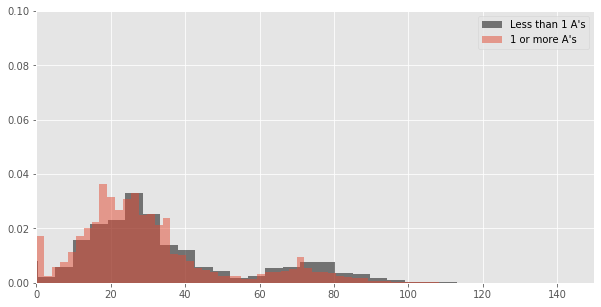

In [273]:
for l in ['A']:
    test = evaluate([TileCondition(l, 1, "<")])
test

In [200]:
## fig, ax = plt.subplots()
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','?']
for l in letters:
    for i in range(0,1):
        print (l)
        tdf = df_good_p2[df_good_p2.rack.apply(lambda x:x.count(l)<2)]
        tdf2 = df_good_p2[df_good_p2.rack.apply(lambda x:x.count(l)==2)]
#        print(min(tdf["turn_score"]), max(tdf["turn_score"]))
        if (tdf.shape[0]):
            print("mean score with {:} {:}'s: {:}, ({:})".format(i, l, round(np.mean(tdf["turn_score"]), 2), 
                                                       tdf.shape[0]))
            print("mean score with at least 1 {:}'s: {:}, ({:})".format( l, round(np.mean(tdf2["turn_score"]), 2), 
                                                       tdf2.shape[0])) 
            print("p-value: {:}".format(stats.ttest_ind(tdf.turn_score, tdf2.turn_score).pvalue))
#            print(tdf["gamenum"], print(tdf["rack"]))
        ax.hist(tdf["turn_score"], bins=100, density=True, alpha = .5, color='black')
        ax.hist(tdf2["turn_score"], bins=100, density=True, alpha=.5)
        ax.set_xlim(left=0, right=125)
        print(" ")  
    break;
    print(" ")

A
mean score with 0 A's: 34.63, (329797)
mean score with at least 1 A's: 30.43, (32898)
p-value: 2.0056875971696334e-213
 
